In [4]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
root_dir = Path(os.getcwd())

# Formant Feature Extraction

In [7]:
db = pd.read_csv(root_dir/'feature_database'/'on'/'0d2bcf9d_nohash_0.csv')

In [20]:
sound_db = db[db[' phoneme']=='sounding'].replace(to_replace='--undefined--', value=0)

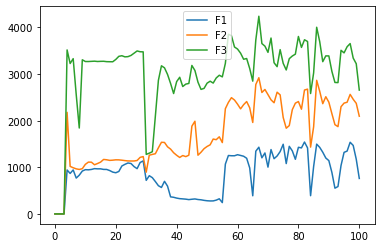

In [28]:
plt.plot(sound_db[' F1'], label = 'F1')
plt.plot(sound_db[' F2'], label = 'F2')
plt.plot(sound_db[' F3'], label = 'F3')
# plt.plot(sound_db[' F4'], label = 'F4')
# plt.plot(sound_db[' F5'], label = 'F5')

plt.legend()
plt.show()

# Spectrogram Feature Extraction

In [30]:
stdb = pd.read_csv(root_dir/'short_text_database'/'on'/'0d2bcf9d_nohash_0.csv')

In [48]:
stdb = stdb.rename(columns={'File type = "ooTextFile"': 'val'})

In [52]:
stdb.iloc[0:9]['val']

0    Object class = "Sound 2"
1                           0
2                           1
3                       16000
4                    6.25e-05
5                   3.125e-05
6                           1
7                           1
8                           1
Name: val, dtype: object

In [53]:
for i in range(5):
    f.readline()

nx = int(f.readline()[:-1])

for i in range(4):
    f.readline()
    
ny = int(f.readline()[:-1])

for i in range(2):
    f.readline()
    
new_spectrogram = np.array([[0]*ny]*nx, dtype='float')
for y in reversed(range(ny)):
    for x in range(nx):
        new_spectrogram[x][y] = float(f.readline()[:-1])

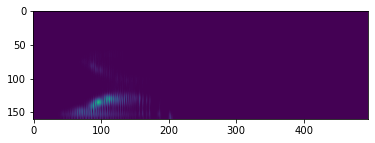

In [54]:
plt.imshow(new_spectrogram.T)